In [1]:
#pip install pandas
#pip install openpyxl
#pip install matplotlib
#pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
hotels = pd.read_excel('hotels.xlsx')

In [4]:
preferences = pd.read_excel('preferences.xlsx')

In [5]:
guests = pd.read_excel('guests.xlsx')

In [6]:
files = [hotels, preferences, guests]

In [7]:
for file in files[:2]:
    file = file.iloc[:, 1:]

In [8]:
guests.rename(columns={'Unnamed: 0': 'index'}, inplace=True)

Function for checking in guests for 3rd and 4th ways

1. First, we check in all the cheapest hotels - sort the table with rooms hotels_new by price.
2. For each hotel in order: get a list of guests based on order and priority.

Create a dataset for each hotel - temporary. Create a cumulative dataset.

For each hotel, select only those guests for whom this hotel is in the priorities. We get a dataset of the form "hotel - guest - priority - rn". Sort by priority, then by guest. Thus, first, the guests for whom the hotel is one of the best in terms of priority, by check-in order, and so on will be checked in. We want to avoid a situation in which a client who registered in the database earlier, but chose hotel X last in the priority list, will be checked in, despite the fact that the next guest chose this hotel, say, one of the best, but will not get into it. We reduce the risk of getting a low level of satisfaction with the check-in.

It is also necessary to create datasets with checked-in and unchecked guests, so that in the new iteration we can access the changed list of guests - the dataset with guests will change.

In [46]:
def distribution_by_hotels(sorted_values, sort_values_order):
    priorities = []
    for i in range(1, max(preferences['priority']) + 1):
        priorities.append(i)
    hotels_draft = hotels.copy()
    df_draft = pd.DataFrame()
    dict_hotels = hotels_draft.groupby(sorted_values)['hotel'].apply(list).to_dict()
    checked_in_full = pd.DataFrame(columns = ['guest'])
    for key in sorted(dict_hotels, reverse = sort_values_order):
        for hotel in dict_hotels[key]:
            df_draft_0 = preferences[(preferences['hotel'] == hotel) & ~preferences['guest'].isin(checked_in_full['guest'])] #исключаем тех, кого заселили
            df_draft = pd.concat([df_draft, df_draft_0], ignore_index=True)
        for priority in priorities:
            df_priority = df_draft[(df_draft['priority'] == priority) & ~df_draft['guest'].isin(checked_in_full['guest'])] #исключить тех, кого заселили
            for hotel in dict_hotels[key]:
                checked_in_guests = df_priority[df_priority['hotel'] == hotel]
                free_rooms = hotels_draft[hotels_draft['hotel'] == hotel]['rooms'].values[0]
                checked_in_guests = checked_in_guests[:free_rooms]
                checked_in_full = pd.concat([checked_in_full, checked_in_guests], ignore_index=True)
                hotels_draft.loc[hotels_draft['hotel'] == hotel, 'rooms'] -= len(checked_in_guests)
        df_draft = pd.DataFrame()
    if len(checked_in_full) == len(guests):
        print("All guests are checked in.")     
    else:
        print(len(checked_in_full), "guests are checked in. The rest will be checked in according to the order of hotels.")
        leftovers_expensive = preferences[~preferences['guest'].isin(checked_in_full['guest'])]['guest'].unique() #3990
        check = checked_in_full.pivot_table(values= ['guest'], index='hotel', aggfunc={'guest':'count'})
        check = check.reset_index()
        check = pd.merge(check, hotels, on = 'hotel', how = 'left') #53 hotels are not full - too expensive
        df_for_leftovers_expensive = pd.merge(hotels_new, check[check['guest'] != check['rooms']], on = 'hotel', how = 'inner') 
        df_for_leftovers_expensive = df_for_leftovers_expensive[df_for_leftovers_expensive['room_number'] <= df_for_leftovers_expensive['guest']]
        df_for_leftovers_expensive = df_for_leftovers_expensive.sort_values('price_y')
        df_for_leftovers_expensive = df_for_leftovers_expensive[:len(leftovers_expensive)]
        df_for_leftovers_expensive['leftovers'] = leftovers_expensive
        df_for_leftovers_expensive = df_for_leftovers_expensive[['leftovers', 'hotel']]
        df_for_leftovers_expensive['priority'] = 0
        df_for_leftovers_expensive = df_for_leftovers_expensive.rename(columns={'leftovers': 'guest'})
        checked_in_full = pd.concat([checked_in_full, df_for_leftovers_expensive])
    checked_in_full = checked_in_full.rename(columns={'priority': 'priority_number'})
    checked_in_full = pd.merge(checked_in_full, guests, on = 'guest', how = 'left')
    checked_in_full = pd.merge(checked_in_full, hotels, on = 'hotel', how = 'left')
    checked_in_full['price_final'] = checked_in_full['price'] * (1 - checked_in_full['discount'])
    return checked_in_full

Visualisation part. Let us divide hotels for 4 categories of price and make analytics according to them.

In [10]:
min(hotels['price']) #min price for defining categories of price

50

In [11]:
max(hotels['price']) #max price for defining categories of price

299

4 categories from 50 to 300 (for beauty numbers) means that we divide categories for 250/4 = 62,5 buckets:
50 - 112,5 ;
112, 5 - 175 ;
175-237,5 ;
237,5 - 300.

In [12]:
categories = ['Economy', 'Affordable', 'Premium', 'Luxury']

Visualisation part will include main bar charts with information of number of guests and total revenue according to categories, and guests' satisfaction as this is important for reputation ang long-term clients. 

In [13]:
def df_visualisation(merged_distribution):
    pivot_for_visualisation = merged_distribution.pivot_table(values= ['guest', 'rooms', 'price', 'price_final'], index='hotel', 
                                                          aggfunc={'guest':'count', 'rooms':'mean', 'price':'mean', 'price_final':'sum'}, observed=False)
    pivot_for_visualisation = pivot_for_visualisation.reset_index()
    # Assign price categories to hotels and order categories according to lowest and highest 
    conditions = [
    (pivot_for_visualisation['price'] >= 50) & (pivot_for_visualisation['price'] < 112.5),
    (pivot_for_visualisation['price'] >= 112.5) & (pivot_for_visualisation['price'] < 175),
    (pivot_for_visualisation['price'] >= 175) & (pivot_for_visualisation['price'] < 237.5),
    (pivot_for_visualisation['price'] >= 237.5)]
    
    pivot_for_visualisation['price_category'] = np.select(conditions, categories, default='Unknown')
    pivot_for_visualisation['price_category'] = pd.Categorical(pivot_for_visualisation['price_category'], categories=categories, ordered=True)
    
    pivot_for_visualisation['check_in_percentage'] = pivot_for_visualisation['guest'] / pivot_for_visualisation['rooms']
    return pivot_for_visualisation

In [14]:
# Universal color palette for all charts
color_palette = ['#88c4e8', '#ff9b85', '#ffce64', '#7c8eb1']

# Function for building a bar chart with labels
def plot_bar_chart(data, title, xlabel, ylabel, categories=None):
    plt.figure(figsize=(6, 4))  # Size
    ax = data.plot(kind='bar', color=color_palette)  # Column chart with universal color palette
    
    # Adding captions to columns
    for p in ax.patches:
        value = round(p.get_height(), 2)  # Rounding the number for labeling
        ax.annotate(f'{value}',  # Text with numbers
                    (p.get_x() + p.get_width() / 2, p.get_height()),  # Central position
                    ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')
    
    # Bar chart settings
    plt.title(title, fontsize=12)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    if categories:
        plt.xticks(ticks=range(len(categories)), labels=categories)  # Label X
    plt.xticks(rotation=45, ha='right')  # Rotate labels of X
    plt.tight_layout()  # Improved element layout
    plt.show()

# Function for creating a scatterplot and adding labels to key points. highlight_points - list of indices for points that should be signed (default None)
# xticks - X-axis labels (default None)
def plot_scatter(x, y, title, xlabel, ylabel, highlight_points=None, color='green', xticks=None):
    # Building a scatter plot
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.5, color=color)

    # Set up X-axis ticks (if xticks is passed)
    if xticks is not None:
        plt.xticks(xticks)

    # Sign key points if they are transmitted
    if highlight_points is not None:
        for idx in highlight_points:
            plt.text(x[idx], y[idx], f'({y[idx]:.2f})', fontsize=7, ha='center', va='bottom', color='red')

    # Graph settings
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Graph depiction
    plt.tight_layout()
    plt.show()

# Universal function for plotting all graphs
def plot_all_graphs(pivot_for_visualisation, categories):
    # Data for graphs
    data_list = [
        (pivot_for_visualisation['price_category'].value_counts().reindex(categories), 
         'Hotels Price Distribution', 'Price Category', 'Amount of Hotels', categories),
        
        (pivot_for_visualisation.groupby('price_category', observed=False)['guest'].sum(), 
         'Distribution of Guests by Price Category', 'Price Category', 'Total Number of Guests', categories),
        
        (pivot_for_visualisation.groupby('price_category', observed=False)['price_final'].sum(), 
         'Total Revenue Distribution', 'Price Category', 'Total Revenue', categories)
    ]

    # Loop to build all bar charts
    for data, title, xlabel, ylabel, categories in data_list:
        plot_bar_chart(data, title, xlabel, ylabel, categories)

    # Box plot
    plt.figure(figsize=(6, 4))
    ax = plt.boxplot(pivot_for_visualisation['price_final'], patch_artist=True, notch=True, vert=False, widths=0.7, 
                     medianprops=dict(color='brown', linewidth=2), flierprops=dict(marker='o', color='green', markersize=10, alpha=0.8),
                    boxprops=dict(facecolor='beige', color='brown'))

    plt.title('Distribution of Hotel Revenue (Box Plot)', fontsize=12)
    plt.xlabel('Revenue', fontsize=10)
    plt.yticks([1], ['Hotels'])
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add median
    median_value = round(pivot_for_visualisation['price_final'].median(), 2)
    plt.annotate(f'Median: {median_value}', xy=(median_value, 1), xytext=(median_value + 100, 1.05),
                 arrowprops=dict(arrowstyle="->", color='brown'), fontsize=12, color='brown')

    plt.tight_layout()
    plt.show()
    
    # Revenue distribution by number of guests
    x = pivot_for_visualisation['guest']
    y = pivot_for_visualisation['price_final']

    # Finding key point indices for signatures (minimum and maximum)
    key_points_indices = [x.idxmax(), x.idxmin(), y.idxmax(), y.idxmin()]

    # Calling a function to distribute revenue by number of guests
    plot_scatter(x, y, 
                 title='Scatter Plot of Price Distribution According to Number of Guests',
                 xlabel='Number of Guests',
                 ylabel='Total Revenue of Hotel',
                 highlight_points=key_points_indices, 
                 color='green',
                 xticks=range(int(x.min()), int(x.max())+1, 1))
    
    # Occupancy rate by hotel
    x = pivot_for_visualisation.index  # hotel indexes
    y = pivot_for_visualisation['check_in_percentage']

    # We find the indexes of the 3 most unoccupied hotels
    bottom_3_hotels = pivot_for_visualisation.nsmallest(3, 'check_in_percentage')
    
    # Calling the function for the second graph
    plot_scatter(x, y, 
                 title='Hotel Check-in Percentage',
                 xlabel='Hotel Index',
                 ylabel='Check-in Percentage',
                 highlight_points=bottom_3_hotels.index,
                 color='green',
                 xticks=[])

In [15]:
def plot_satisfaction(merged_distribution):
    # We aggregate preferences by guests, creating a list of hotels by priority
    df_guest_preferences = preferences.groupby('guest')['hotel'].apply(list).reset_index()
    df_guest_preferences.columns = ['guest', 'priority']
    
    # We merge data of preferences and actual settlement
    df_for_satisfaction = pd.merge(df_guest_preferences, merged_distribution, on='guest')
    
    # Function for calculating satisfaction
    def calculate_satisfaction(row):
        # Find the index of the actual hotel in the list of preferences
        preferences_list = row['priority']
        
        if row['hotel'] in preferences_list:
            satisfaction = 1 - preferences_list.index(row['hotel']) / len(preferences_list)
        else:
            satisfaction = 0  # If the hotel is not on the list of preferences, then satisfaction is minimal
        return satisfaction
    
    # We apply the function for each guest
    df_for_satisfaction['satisfaction'] = df_for_satisfaction.apply(calculate_satisfaction, axis=1)
    
    # A histogram to display the distribution of satisfaction
    plt.figure(figsize=(6, 4))
    plt.hist(df_for_satisfaction['satisfaction'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Guest Satisfaction', fontsize=14)
    plt.xlabel('Satisfaction Level', fontsize=12)
    plt.ylabel('Number of Guests', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    # Seaborn graph
    # We aggregate the data: for each hotel we calculate the average guest satisfaction
    hotel_satisfaction = df_for_satisfaction.groupby('hotel')['satisfaction'].mean()
    
    # Let's prepare the data for display
    data = hotel_satisfaction.values.reshape(1, -1)
    
    # We build a graph without axes and labels
    plt.figure(figsize=(14, 2))  # We reduce the height, since there are no signatures
    plt.imshow(data, aspect='auto', cmap='YlGnBu', interpolation='nearest')
    
    # Adding a color scale
    plt.colorbar(label='Satisfaction')
    
    # Removing the axes
    plt.xticks([])  
    plt.yticks([])
    
    # Adding a title
    plt.title('Guest Satisfaction by Hotel', fontsize=16)
    
    # Improving chart interpretation
    plt.tight_layout()
    
    # Graph depiction
    plt.show()

Dataset with rooms for each hotel. We will use it when applying functions for checking in.

In [17]:
hotels_new = pd.DataFrame(columns = ['room_number', 'hotel', 'rooms', 'price'])
for i in hotels['hotel']:
    room_numbers = hotels[hotels['hotel'] == i]['rooms'].values[0]
    price = hotels[hotels['hotel'] == i]['price'].values[0]
    rooms = hotels[hotels['hotel'] == i]['price'].values[0]
    a = 0
    for j in range(room_numbers):
        a +=1 
        hotels_new.loc[len(hotels_new)] = [a, i, room_numbers, price]
    hotels_new

Part 1

In [18]:
random_numbers = np.random.permutation(len(hotels_new))

In [19]:
hotels_new['random_number'] = random_numbers

In [20]:
hotels_new2 = hotels_new[hotels_new['random_number'] <= 3999]

In [21]:
merged_distribution = pd.merge(hotels_new2, guests, left_on = 'random_number', right_on = 'index', how = 'left')

In [22]:
merged_distribution['price_final'] = merged_distribution['price'] * (1 - merged_distribution['discount'])

New price order - my own creation to increase total revenue, still it will increase reputation risks and damage guests' loyalty 

In [23]:
# hotels_new_price_order = hotels_new.sort_values(by='price', ascending=False)

In [24]:
# hotels_new_price_order = hotels_new_price_order.head(4000)

In [25]:
# random_numbers2 = np.random.permutation(len(hotels_new_price_order))

In [26]:
# hotels_new_price_order['random_number'] = random_numbers2

In [27]:
# merged_distribution_order = pd.merge(hotels_new_price_order, guests, left_on = 'random_number', right_on = 'index', how = 'left')

In [28]:
# merged_distribution_order['price_final'] = merged_distribution_order['price'] * (1 - merged_distribution_order['discount'])

Visualisation part

In [29]:
pivot_for_visualisation = df_visualisation(merged_distribution)

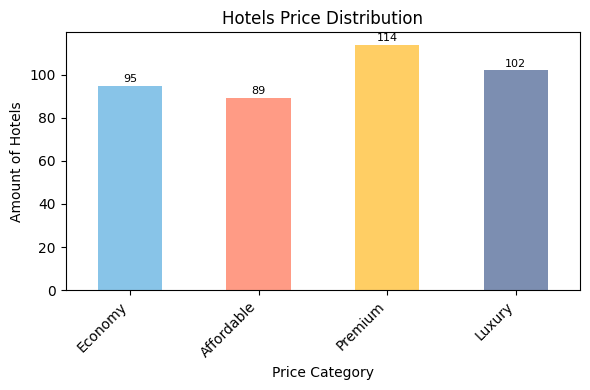

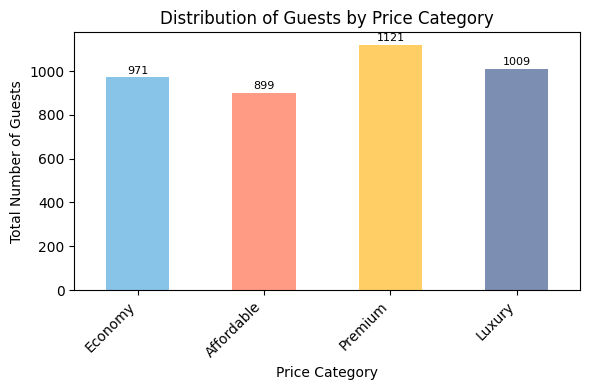

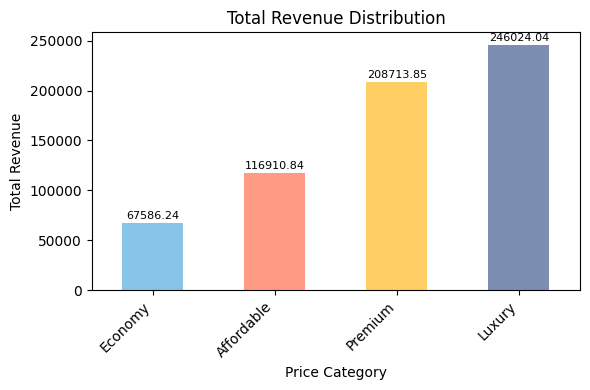

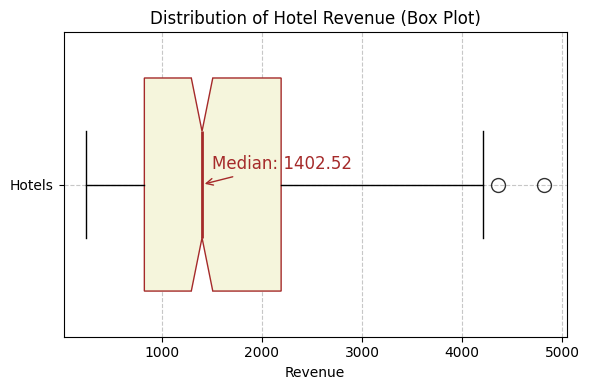

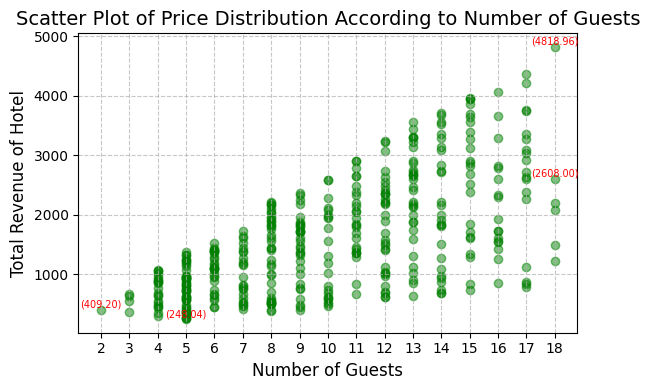

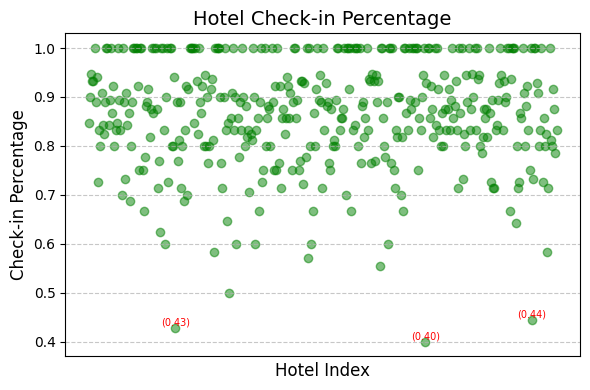

In [30]:
plot_all_graphs(pivot_for_visualisation, categories)

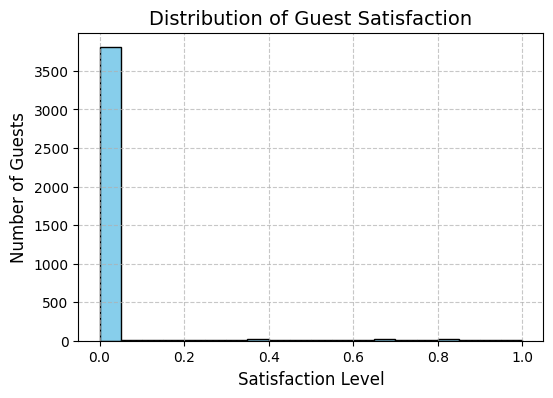

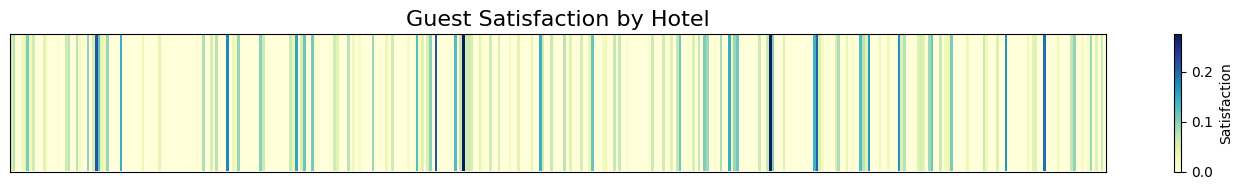

In [31]:
plot_satisfaction(merged_distribution)

Part 2

In [32]:
list_priorities = preferences['priority'].unique().tolist()

# Копируем оригинальные данные
hotels_rest = hotels.copy()
hotels_rest['rest'] = hotels['rooms']
hotels_rest['guests'] = 0

# Создаем DataFrame для гостей, которые еще не заселились
not_checked_in_guests = guests.copy()

# Процесс заселения
checked_in_guests = pd.DataFrame()  # Пустой DataFrame для заселенных гостей

for priority in list_priorities:
    # Фильтрация предпочтений по приоритетам
    start_df = preferences[(preferences['priority'] == priority) & preferences['guest'].isin(not_checked_in_guests['guest'])].copy()
    
    # Порядковый номер для каждого гостя в отеле
    start_df['rn'] = start_df.groupby('hotel').cumcount() + 1
    
    # Объединение с данными об отелях
    df_hotels = pd.merge(start_df, hotels_rest, on='hotel', how='left')
    
    # Обновление списка заселенных гостей
    checked_in_guests = pd.concat([checked_in_guests, df_hotels[df_hotels['rn'] <= df_hotels['rest']]], ignore_index=True)
    
    # Обновление списка не заселенных гостей
    not_checked_in_guests = df_hotels[df_hotels['rn'] > df_hotels['rest']]
    
    # Обновление состояния отелей
    hotels_rest = df_hotels.groupby('hotel').agg({'guests': 'count', 'rooms': 'mean', 'price': 'mean'}).reset_index()
    hotels_rest['rest'] = hotels_rest['rooms'] - hotels_rest['guests']

# Гостиницы, в которых осталось место
check_df = preferences[~preferences['guest'].isin(checked_in_guests['guest'])]
guests_leftovers = check_df['guest'].unique().tolist()
x = len(guests_leftovers)

# Отели, в которых есть свободные номера и сортировка по цене
hotels_for_leftovers = hotels_rest[hotels_rest['rest'] > 0].sort_values('price')

# Получаем комнаты для оставшихся гостей
rooms_leftovers = pd.merge(hotels_new, hotels_for_leftovers, on='hotel', how='inner')
rooms_leftovers = rooms_leftovers[rooms_leftovers['room_number'] > rooms_leftovers['guests']].sort_values('price_x')[:x]

# Присваиваем оставшихся гостей
rooms_leftovers['guest'] = guests_leftovers
rooms_leftovers['priority'] = 0

# Переименовываем столбцы
rooms_leftovers = rooms_leftovers.rename(columns={'price_y': 'price', 'rooms_x': 'rooms'})

# Объединяем все данные
final_guests = pd.concat([checked_in_guests[['guest', 'hotel', 'price', 'rooms']], rooms_leftovers[['guest', 'hotel', 'price', 'rooms']]], ignore_index=True)

# Применяем скидки
final_guests = pd.merge(final_guests, guests, on='guest', how='left')
final_guests['price_final'] = final_guests['price'] * (1 - final_guests['discount'])

In [33]:
pivot_for_visualisation = df_visualisation(final_guests)

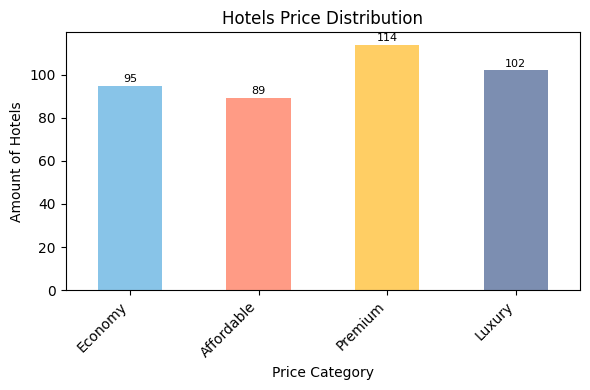

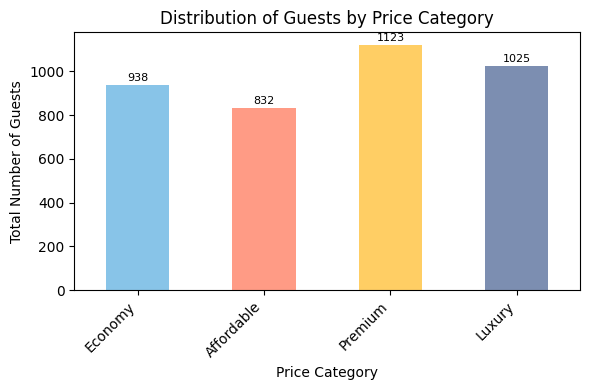

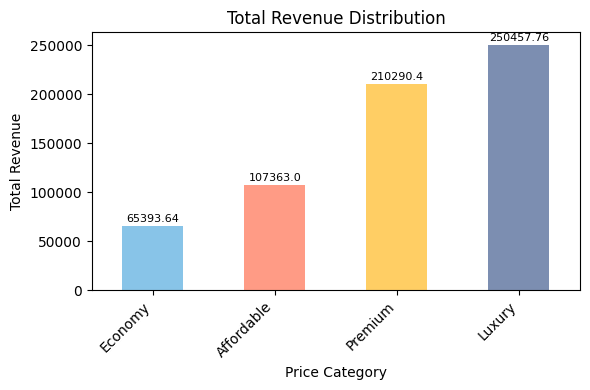

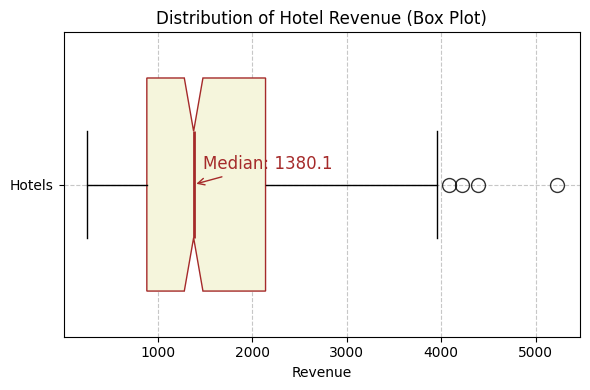

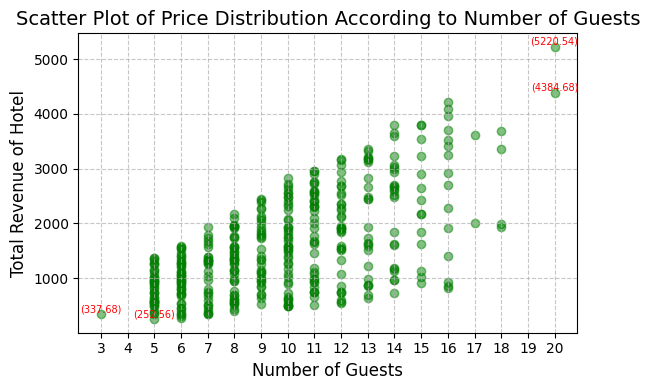

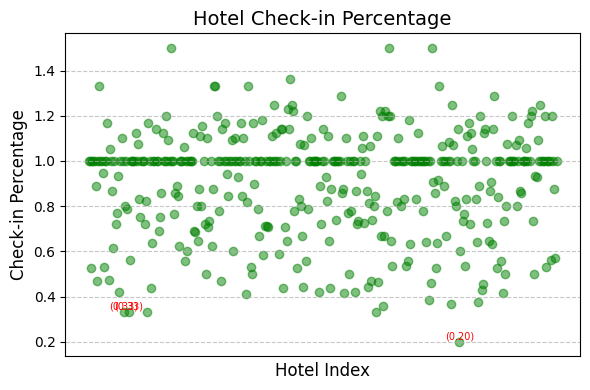

In [34]:
plot_all_graphs(pivot_for_visualisation, categories)

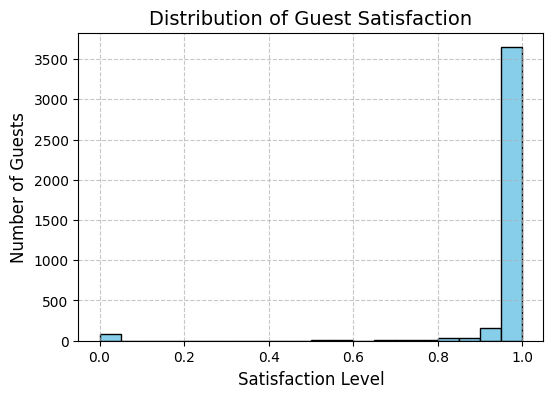

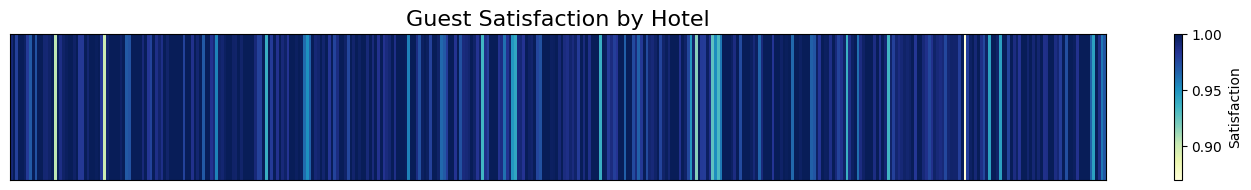

In [35]:
plot_satisfaction(final_guests)

Part 3

Hotels are sorted by price starting with the cheapest hotel. 

In [36]:
hotels_new = hotels_new.sort_values(by = ['price', 'hotel', 'room_number'])

In [37]:
checked_in_full = distribution_by_hotels('price', False)

50 29
52 47
53 56
54 115
55 143
56 203
57 232
58 242
59 267
60 281
61 298
64 311
65 324
66 360
67 371
68 409
69 430
71 439
72 452
73 515
74 543
75 582
76 614
77 626
78 638
79 660
81 674
82 690
83 702
84 707
85 773
88 781
90 794
91 806
92 837
93 860
94 876
95 902
96 914
97 932
98 979
101 991
102 1037
104 1044
107 1055
108 1077
109 1094
112 1110
113 1120
115 1136
116 1171
117 1178
120 1228
121 1246
122 1263
123 1279
125 1294
126 1314
127 1363
128 1371
129 1378
130 1384
132 1427
133 1452
134 1483
135 1522
136 1538
139 1548
140 1618
141 1630
143 1635
145 1700
146 1731
149 1743
153 1761
154 1794
156 1813
157 1838
158 1853
159 1875
160 1928
162 1940
163 1954
165 1977
166 1999
167 2035
168 2045
169 2063
170 2090
171 2106
172 2141
175 2180
176 2229
178 2255
179 2267
180 2282
181 2310
182 2318
183 2371
184 2378
185 2383
186 2400
187 2436
189 2447
192 2486
193 2505
194 2524
195 2548
196 2560
197 2606
198 2630
200 2650
201 2674
202 2714
203 2747
204 2755
205 2773
206 2784
207 2800
208 2874
209 29

In [38]:
pivot_for_visualisation = df_visualisation(checked_in_full)

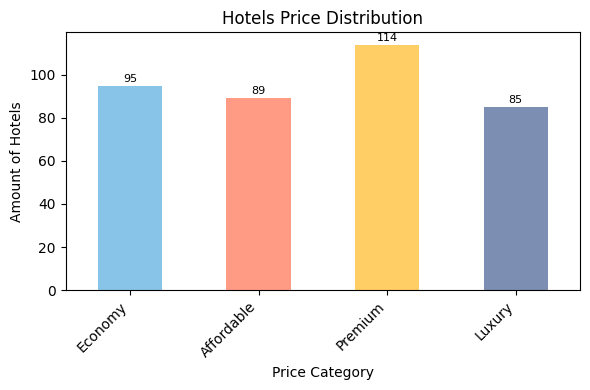

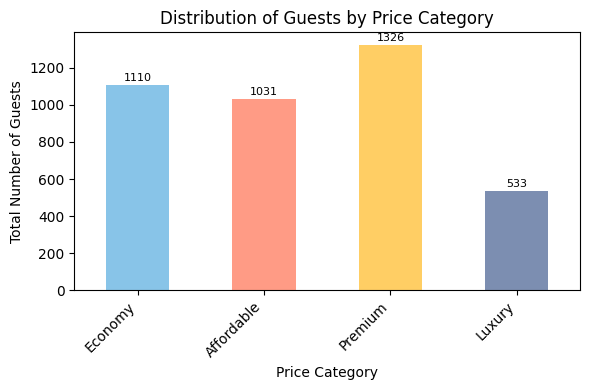

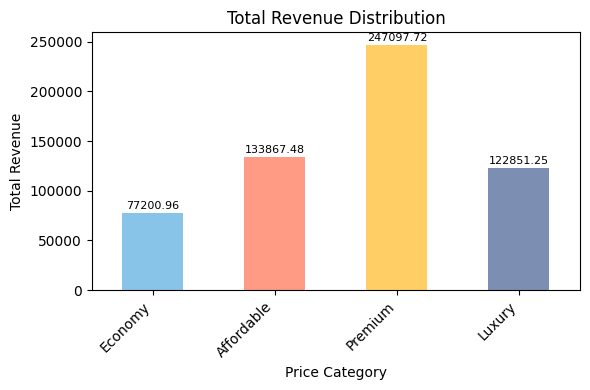

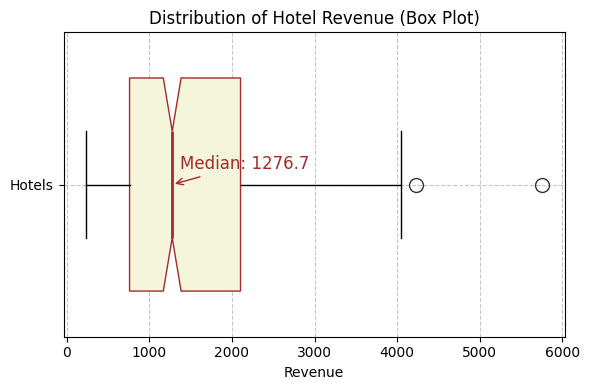

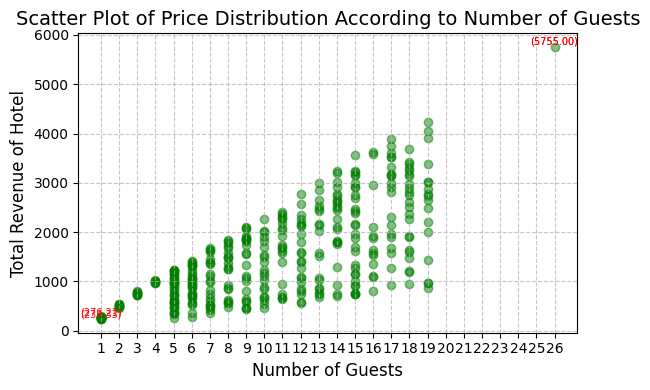

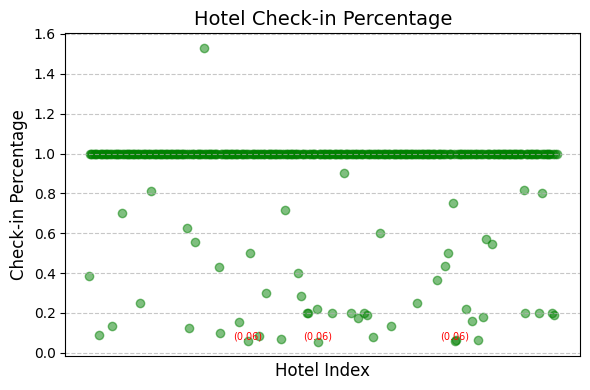

In [39]:
plot_all_graphs(pivot_for_visualisation, categories)

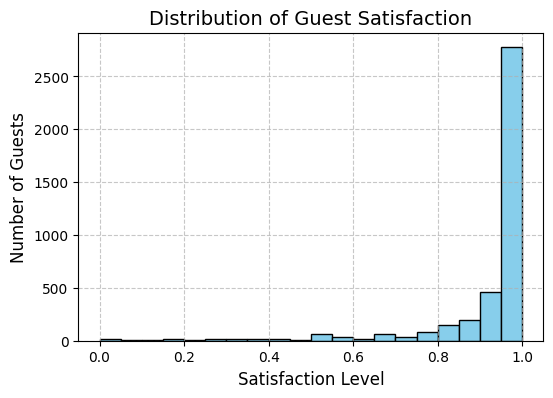

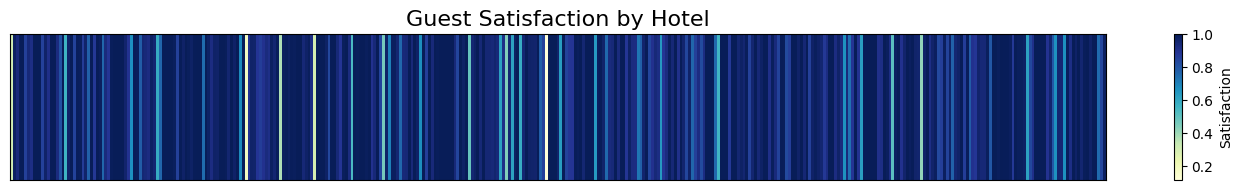

In [40]:
plot_satisfaction(checked_in_full)

Part 4

Hotels are sorted by availability starting with the most roomy hotel. 

In [42]:
checked_in_full = distribution_by_hotels('rooms', True)

19 342
18 810
17 1252
16 1572
15 2127
14 2477
13 2750
12 3062
11 3348
10 3618
9 3827
8 3940
7 3964
6 3984
5 4000
All guests are checked in.


In [43]:
pivot_for_visualisation = df_visualisation(checked_in_full)

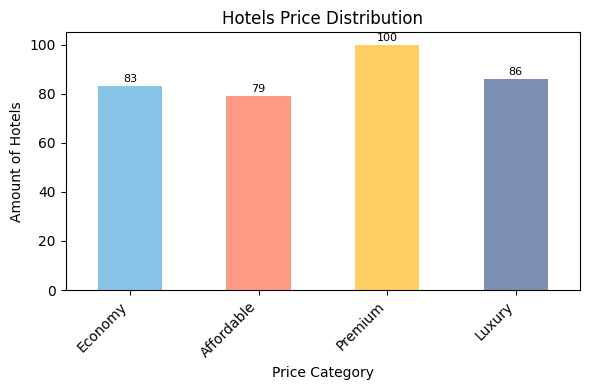

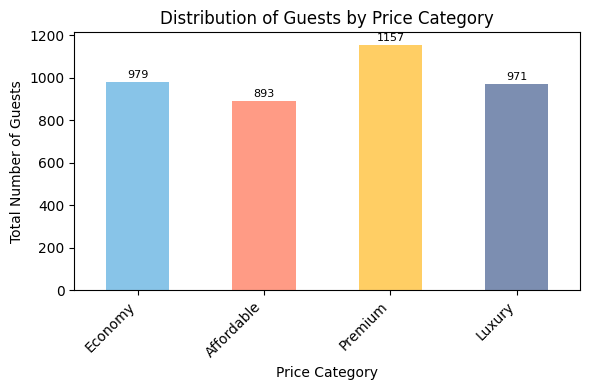

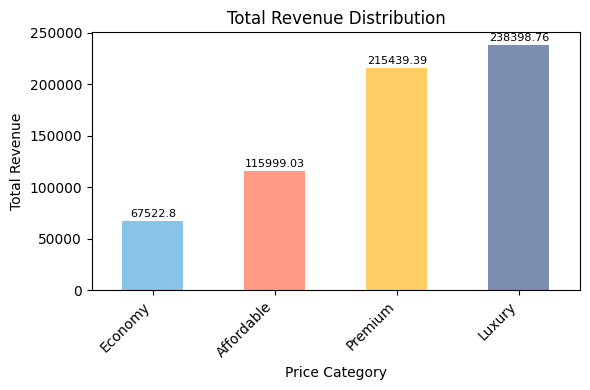

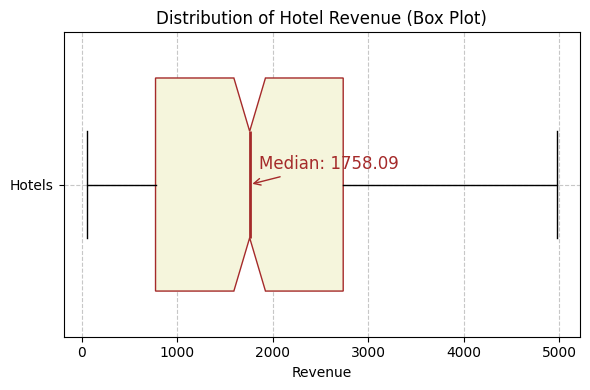

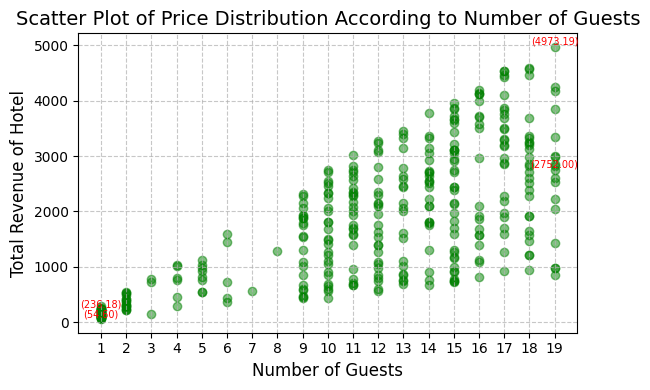

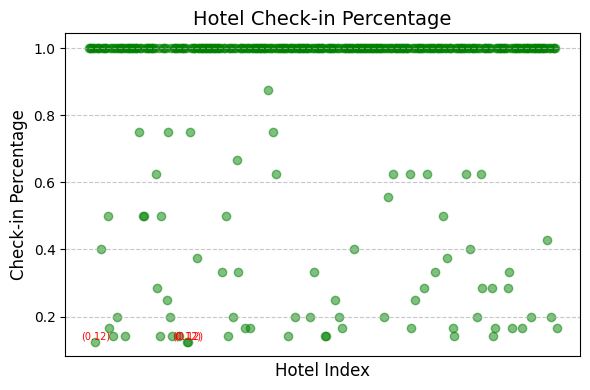

In [44]:
plot_all_graphs(pivot_for_visualisation, categories)

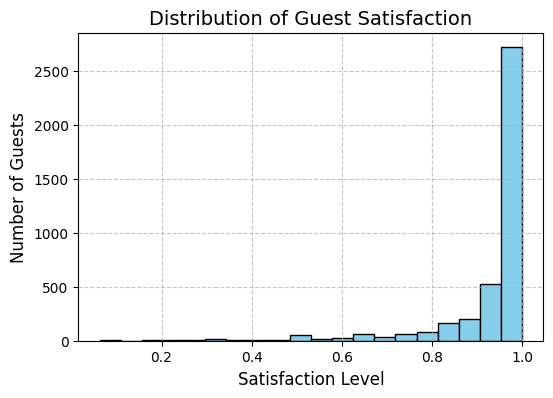

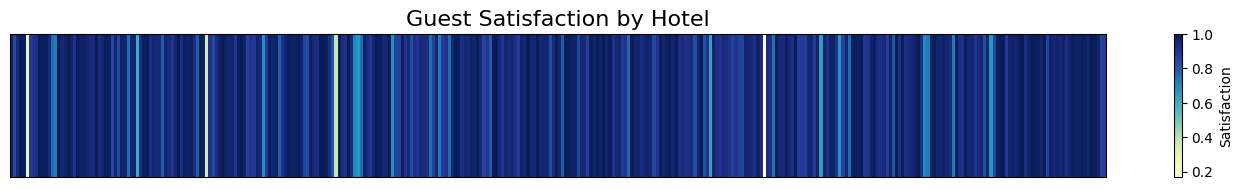

In [45]:
plot_satisfaction(checked_in_full)